In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier


import warnings
warnings.filterwarnings(action='ignore')

In [35]:
data = pd.read_csv('../data/data_final.csv')

In [36]:
data

,Race_ID,Trap,Odds,BSP,Public_Estimate,Last_Run,Distance_All,Finish_All,Distance_Places_All,Races_All,...,Early_380,Grade_380,Time_380,Early_Time_380,Stay_380,Favourite,Finished,Wide_380,Dist_By,Winner
0,0,6,2.75,4.00,1,12,456.47,4.09,402.86,17,...,2.000000,4.00,17.84,3.63,0.500000,6.0,4,0.000000,-10.50000,0
1,0,3,5.00,7.60,4,5,410.48,3.53,414.00,21,...,3.430000,3.29,24.18,3.70,0.280000,6.0,1,0.140000,-4.71000,1
2,0,5,5.00,9.40,6,9,386.45,3.39,380.00,31,...,3.430000,3.71,24.06,3.67,-0.430000,6.0,3,0.000000,-2.86000,0
3,0,4,7.00,7.80,5,9,380.00,3.03,380.00,21,...,2.430000,4.43,24.14,3.65,0.280000,6.0,2,0.000000,-2.71000,0
4,0,2,5.00,5.10,2,13,385.00,2.59,388.33,40,...,3.140000,2.71,24.05,3.64,-0.430000,6.0,6,0.000000,-2.32000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12001,2000,4,3.50,4.67,3,4,408.19,3.25,383.91,52,...,5.000000,5.71,24.13,3.75,-2.000000,1.0,4,0.000000,-3.50000,0
12002,2000,2,7.00,9.36,6,8,418.62,3.82,412.00,58,...,5.000000,4.86,20.81,3.73,-0.290000,1.0,3,0.000000,-12.43000,0
12003,2000,5,5.00,4.35,2,7,400.00,4.05,410.00,9,...,4.750000,6.00,24.36,3.74,-0.750000,1.0,6,0.000000,-4.75000,0
12004,2000,1,4.00,3.86,1,3,436.36,4.82,442.00,22,...,3.487433,5.71,24.13,3.74,-0.056749,1.0,2,0.068085,-4.48688,0


In [52]:
from sklearn.cross_decomposition import PLSRegression

def preprocess_inputs(df, target='Finished', n_components=10, degree=2):
    df = df.copy()
    df = df.drop(['Race_ID', 'Finished', 'Winner'], axis=1, errors='ignore')

    if target == 'Winner':
        y = df['Winner']
        X = df.drop('Winner', axis=1)
    elif target == 'Finished':
        y = df['Finished']
        X = df.drop('Finished', axis=1)
    elif target == 'Position':
        y = df['Position']
        X = df.drop(['Position'], axis=1)

    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False)
    X_poly = poly.fit_transform(X)
    X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.columns))

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, train_size=0.7, shuffle=True, random_state=1)

    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    # Apply PLS regression
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_train, y_train)

    return X_train, X_test, y_train, y_test, pls



In [53]:
data['Position'] = data['Finished'].apply(lambda x: min(x, 6))

In [54]:
X_train, X_test, y_train, y_test, pls = preprocess_inputs(data, target='Position', n_components=10)

In [55]:
# Extract feature importances
feature_importances = np.abs(pls.coef_).ravel()
feature_names = X_train.columns

In [56]:
# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})


In [57]:
# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


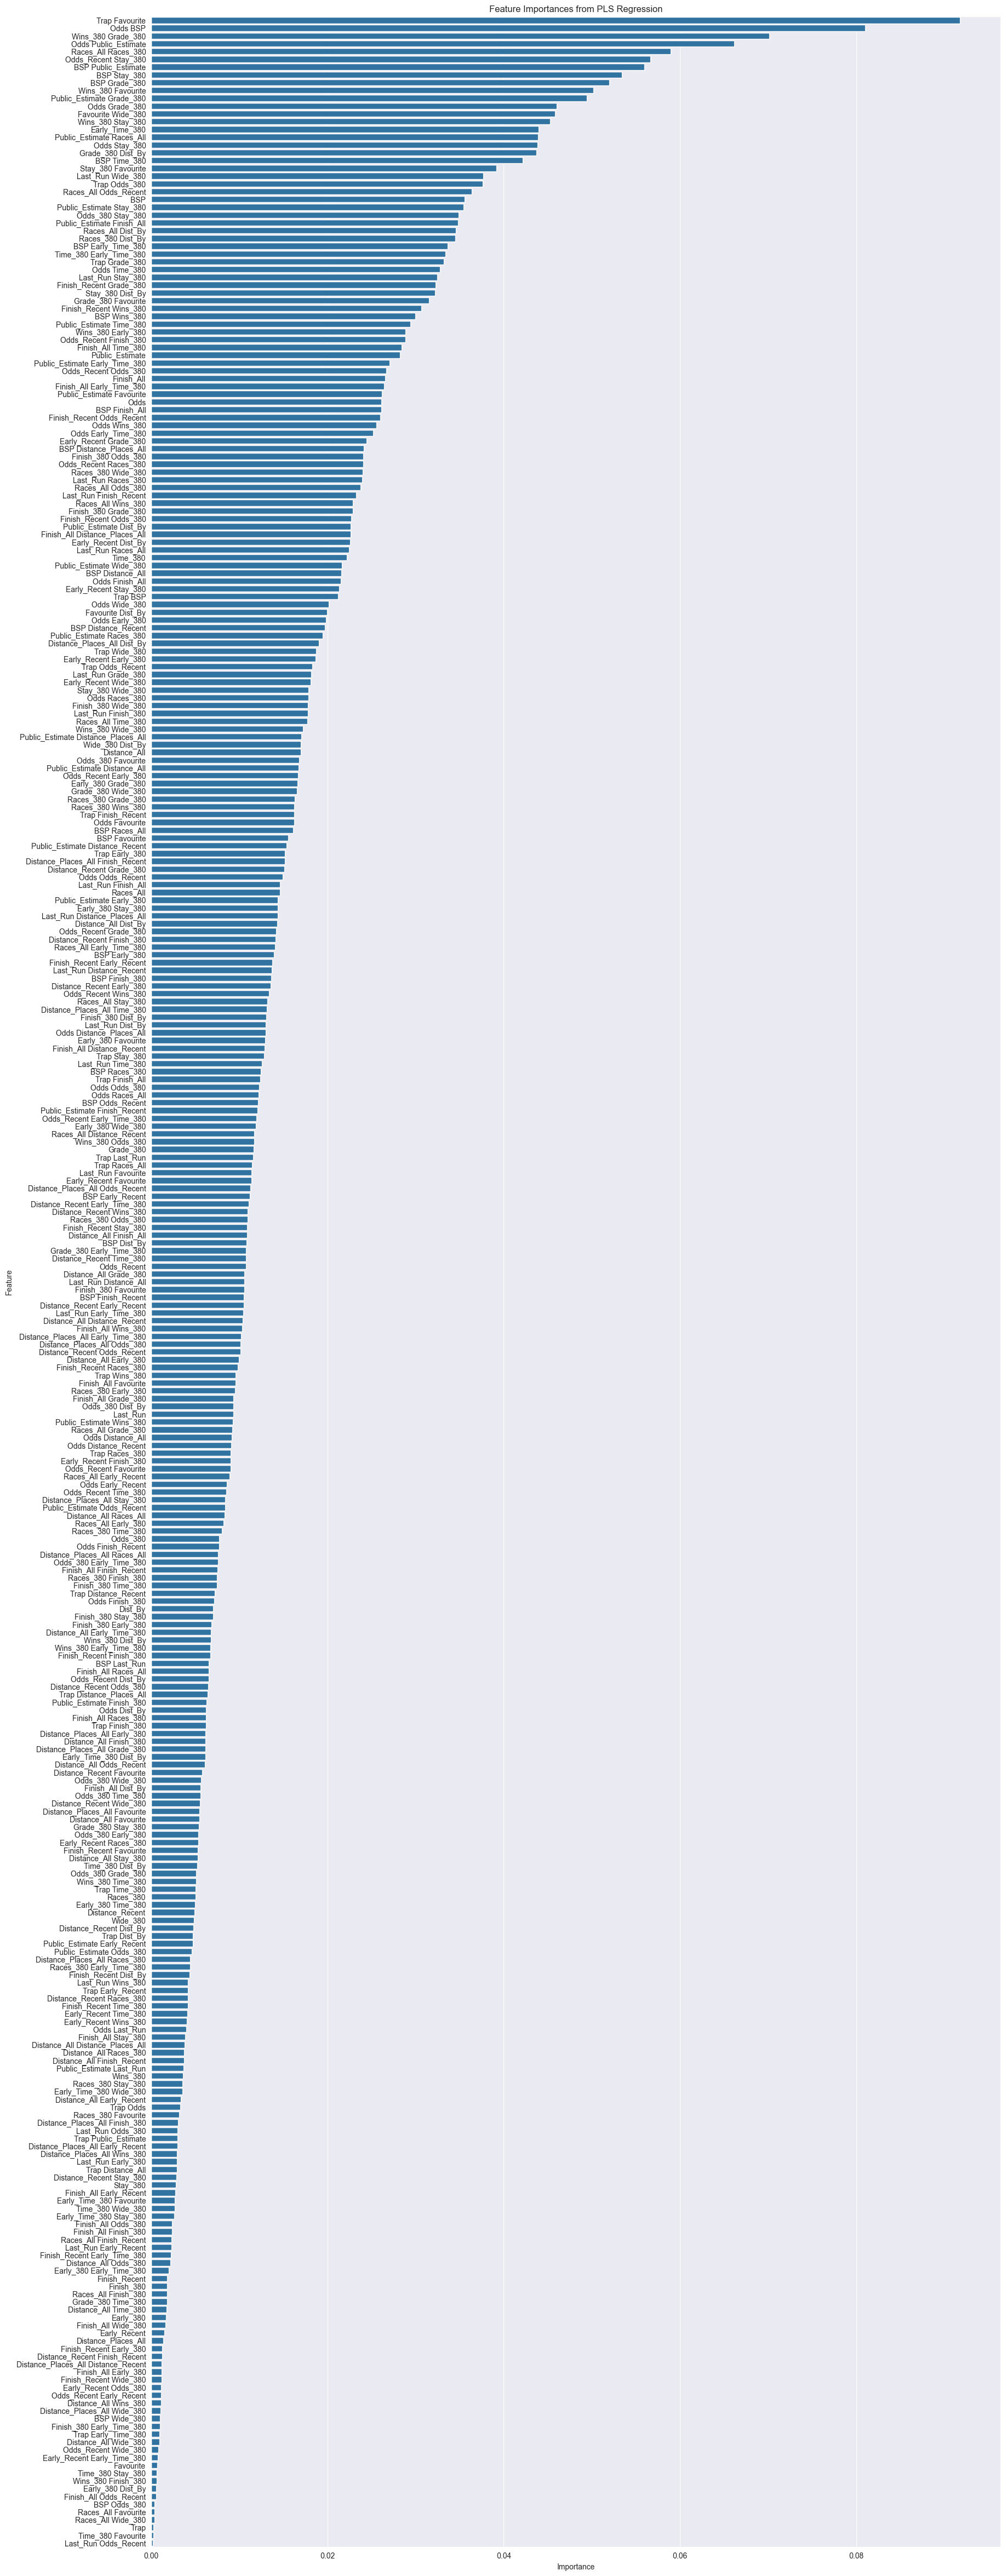

In [58]:
# Plot feature importances
plt.figure(figsize=(20, 60))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from PLS Regression')
plt.show()

In [59]:
models = {
    "K nearest neighbors": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000),
    "Support Vector Machine": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Neural Network": MLPClassifier(max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained")

for name, model in models.items():
    test_accuracy = model.score(X_test, y_test) * 100
    print(f"{name} Test Accuracy: {test_accuracy:.2f}%")


K nearest neighbors trained
Logistic Regression trained
Support Vector Machine trained
Decision Tree trained
Neural Network trained
Gradient Boosting trained
K nearest neighbors Test Accuracy: 17.63%
Logistic Regression Test Accuracy: 20.16%
Support Vector Machine Test Accuracy: 21.74%
Decision Tree Test Accuracy: 18.35%
Neural Network Test Accuracy: 18.74%
Gradient Boosting Test Accuracy: 21.43%


In [60]:
# Market prediction accuracy
market_data = list(zip(data['Public_Estimate'], data['Finished']))
total = len(market_data)
correct_predictions = sum([1 for estimate, actual in market_data if estimate == actual])
market_accuracy = correct_predictions / total * 100
print(f'Market Accuracy: {market_accuracy:.2f}%')

Market Accuracy: 21.05%
